##Loading data

In [ ]:
!wget --content-disposition 'https://figshare.com/ndownloader/articles/21331143/versions/3'

--2025-05-10 12:47:15--  https://figshare.com/ndownloader/articles/21331143/versions/3
Resolving figshare.com (figshare.com)... 54.216.15.6, 34.255.146.38, 52.48.143.184, ...
Connecting to figshare.com (figshare.com)|54.216.15.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4796321715 (4.5G) [application/zip]
Saving to: ‘21331143.zip’

21331143.zip        100%[===================>]   4.47G  39.2MB/s    in 2m 0s   

2025-05-10 12:49:15 (38.0 MB/s) - ‘21331143.zip’ saved [4796321715/4796321715]



In [ ]:
# Unzip the downloaded dataset file
!unzip -q 21331143.zip -d UATD_Dataset
print("Dataset extracted successfully!")

# check what's inside
!ls -la UATD_Dataset

Dataset extracted successfully!
total 4683940
drwxr-xr-x 2 root root       4096 May 10 12:50 .
drwxr-xr-x 1 root root       4096 May 10 12:49 ..
-rw-r--r-- 1 root root   79823319 May 10 12:47 UATD_OpenSLT.zip
-rw-r--r-- 1 root root  421934004 May 10 12:47 UATD_Test_1.zip
-rw-r--r-- 1 root root  424608381 May 10 12:47 UATD_Test_2.zip
-rw-r--r-- 1 root root 3869955319 May 10 12:47 UATD_Training.zip


In [ ]:
# Unzip the training dataset
!unzip -q UATD_Dataset/UATD_Training.zip -d UATD_Training
print("Training dataset extracted successfully!")

# Check what's inside the training dataset
!ls -la UATD_Training

Training dataset extracted successfully!
total 12
drwxr-xr-x 3 root root 4096 May 10 12:50 .
drwxr-xr-x 1 root root 4096 May 10 12:50 ..
drwxrwxrwx 4 root root 4096 Sep 14  2022 UATD_Training


In [ ]:
# Unzip the Test_1 dataset
!unzip -q UATD_Dataset/UATD_Test_1.zip -d UATD_Test_1
print("Test_1 dataset extracted successfully!")

# Check what's inside the Test_1
!ls -la UATD_Test_1

Test_1 dataset extracted successfully!
total 12
drwxr-xr-x 3 root root 4096 May 10 12:55 .
drwxr-xr-x 1 root root 4096 May 10 12:55 ..
drwxrwxrwx 4 root root 4096 Sep 14  2022 UATD_Test_1


##Importing

In [ ]:
!pip install opencv-python-headless
!pip install tensorflow
from google.colab import files
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import random
import glob
import xml.etree.ElementTree as ET
from PIL import Image
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, applications, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set warnings to ignore for cleaner output
import warnings
warnings.filterwarnings('ignore')

##Params

In [ ]:
# --- CONSTANTS AND CONFIGURATION ---
# Dataset paths
TRAIN_DIR = "UATD_Training"
TEST_DIR = "UATD_Test_1"
TRAIN_ANNOTATIONS_DIR = "/content/UATD_Training/UATD_Training/annotations"
TEST_ANNOTATIONS_DIR = "/content/UATD_Test_1/UATD_Test_1/annotations"
TRAIN_IMAGES_DIR = "/content/UATD_Training/UATD_Training/images"
TEST_IMAGES_DIR = "/content/UATD_Test_1/UATD_Test_1/images"

# Model parameters
IMAGE_SIZE = (64, 64)  # Width, Height
BATCH_SIZE = 16
LEARNING_RATE = 0.001
FINE_TUNING_LEARNING_RATE = 0.0001
RANDOM_SEED = 42

# Training parameters
INITIAL_EPOCHS = 3  # Reduced for faster execution
FINE_TUNING_EPOCHS = 5  # Reduced for faster execution
EARLY_STOPPING_PATIENCE = 2
REDUCE_LR_PATIENCE = 1
REDUCE_LR_FACTOR = 0.1
MIN_LR = 1e-6

# Data split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Siamese network parameters
SIAMESE_EMBEDDING_DIM = 64
NUM_PAIRS = 500
SIAMESE_BATCH_SIZE = 16

# Visualization parameters
NUM_SAMPLES_TO_VISUALIZE = 3

##Parsing

In [ ]:
def parse_xml_annotations(annotations_dir, images_dir):
    all_annotations = []
    xml_files = glob.glob(os.path.join(annotations_dir, "*.xml"))

    print(f"Found {len(xml_files)} annotation files in {annotations_dir}")

    # Set default extension to .bmp based on what we observed
    default_ext = '.bmp'
    print(f"Using default image extension: {default_ext}")

    for xml_file in xml_files:
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            # Extract filename from the file->filename path
            file_elem = root.find('./file/filename')
            if file_elem is None:
                print(f"Warning: No filename found in {xml_file}")
                continue

            # base filename without extension
            base_filename = file_elem.text

            # extension to filename
            filename = f"{base_filename}{default_ext}"

            # Check if image file exists
            image_path = os.path.join(images_dir, filename)
            if not os.path.exists(image_path):
                print(f"Warning: Image file {filename} not found in {images_dir}")
                continue

            # annotation dictionary
            annotation = {
                'filename': filename,
                'objects': []
            }

            # Extract image dimensions if available
            size_elem = root.find('./size')
            if size_elem is not None:
                width_elem = size_elem.find('width')
                height_elem = size_elem.find('height')
                if width_elem is not None and height_elem is not None:
                    annotation['width'] = int(width_elem.text)
                    annotation['height'] = int(height_elem.text)

            # Extract sonar metadata if available
            sonar_elem = root.find('./sonar')
            if sonar_elem is not None:
                annotation['sonar'] = {}
                for param in sonar_elem:
                    annotation['sonar'][param.tag] = param.text

            # Extract objects (bounding boxes and categories)
            for obj in root.findall('./object'):
                name_elem = obj.find('name')
                if name_elem is None:
                    continue

                name = name_elem.text

                bndbox = obj.find('bndbox')
                if bndbox is None:
                    continue

                # Extract bounding box coordinates
                xmin_elem = bndbox.find('xmin')
                ymin_elem = bndbox.find('ymin')
                xmax_elem = bndbox.find('xmax')
                ymax_elem = bndbox.find('ymax')

                if None in [xmin_elem, ymin_elem, xmax_elem, ymax_elem]:
                    continue

                try:
                    xmin = int(float(xmin_elem.text))
                    ymin = int(float(ymin_elem.text))
                    xmax = int(float(xmax_elem.text))
                    ymax = int(float(ymax_elem.text))

                    # Convert to [x, y, width, height] format
                    width = xmax - xmin
                    height = ymax - ymin

                    # Add object to annotation
                    annotation['objects'].append({
                        'category': name,
                        'bbox': [xmin, ymin, width, height]
                    })
                except (ValueError, TypeError) as e:
                    print(f"Error parsing coordinates in {xml_file}: {e}")

            # Add to all annotations if it has objects
            if annotation['objects']:
                all_annotations.append(annotation)

        except Exception as e:
            print(f"Error parsing {xml_file}: {e}")

    print(f"Successfully parsed {len(all_annotations)} annotations with objects")
    return all_annotations

In [ ]:
def apply_augmentation(image):
    # Make a copy of the input image to avoid modifying the original
    img = image.copy()

    # 1. Random brightness adjustment (important for underwater visibility)
    if random.random() > 0.5:
        factor = random.uniform(0.7, 1.3)
        table = np.array([min(255, i * factor) for i in range(0, 256)]).astype('uint8')
        img = cv2.LUT(img, table)

    # 2. Random contrast adjustment
    if random.random() > 0.5:
        factor = random.uniform(0.7, 1.3)
        mean = np.mean(img, axis=(0, 1), keepdims=True)
        img = np.clip((img - mean) * factor + mean, 0, 255).astype('uint8')

    # 3. Add random Gaussian noise (simulate sonar noise)
    if random.random() > 0.5:
        row, col, ch = img.shape
        mean = 0
        # Vary the amount of noise
        sigma = random.uniform(1, 15)
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row, col, ch)
        img = np.clip(img + gauss, 0, 255).astype('uint8')

    # 4. Random rotation (small angles)
    if random.random() > 0.5:
        angle = random.uniform(-15, 15)
        h, w = img.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    # 5. Random horizontal flip
    if random.random() > 0.5:
        img = cv2.flip(img, 1)

    # 6. Random vertical flip (less common but can be useful for sonar images)
    if random.random() > 0.25:  # Lower probability
        img = cv2.flip(img, 0)

    # 7. Random blur (simulate water turbidity)
    if random.random() > 0.7:  # Less frequent
        blur_size = random.choice([3, 5, 7])
        img = cv2.GaussianBlur(img, (blur_size, blur_size), 0)

    # 8. Random sharpening (enhance object boundaries)
    if random.random() > 0.7:  # Less frequent
        kernel = np.array([[-1, -1, -1],
                           [-1,  9, -1],
                           [-1, -1, -1]])
        img = cv2.filter2D(img, -1, kernel)

    # 9. Random cutout (occlude parts of the image to improve robustness)
    if random.random() > 0.7:
        h, w = img.shape[:2]
        size = min(h, w) // 8  # Size of the cutout
        x = random.randint(0, w - size)
        y = random.randint(0, h - size)
        img[y:y+size, x:x+size] = 0

    return img

def preprocess_image(image_path, target_size=IMAGE_SIZE, augment=False):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image at {image_path}")

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Store original dimensions
    orig_h, orig_w = image.shape[:2]

    # Apply data augmentation if enabled
    if augment:
        image = apply_augmentation(image)

    # Resize image
    image = cv2.resize(image, target_size)

    # Normalize pixel values to [0, 1]
    image = image.astype(np.float32) / 255.0

    return image, orig_h, orig_w

def visualize_augmentations(annotations, images_dir, num_samples=3):
    indices = np.random.choice(len(annotations), min(num_samples, len(annotations)))

    plt.figure(figsize=(15, 4 * num_samples))
    for i, idx in enumerate(indices):
        anno = annotations[idx]
        image_path = os.path.join(images_dir, anno['filename'])

        # Load original image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply multiple augmentations to demonstrate variety
        augmented_1 = apply_augmentation(image)
        augmented_2 = apply_augmentation(image)
        augmented_3 = apply_augmentation(image)

        # Display original image
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(image)
        plt.title("Original")
        plt.axis('off')

        # Display augmented versions
        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(augmented_1)
        plt.title("Augmentation 1")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(augmented_2)
        plt.title("Augmentation 2")
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(augmented_3)
        plt.title("Augmentation 3")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_samples_with_annotations(annotations, images_dir, num_samples=3):
    indices = np.random.choice(len(annotations), min(num_samples, len(annotations)))

    plt.figure(figsize=(15, 5 * num_samples))
    for i, idx in enumerate(indices):
        anno = annotations[idx]
        image_path = os.path.join(images_dir, anno['filename'])

        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display image
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(image)
        plt.title(f"Image: {anno['filename']}")

        # Add bounding boxes and labels
        for obj in anno['objects']:
            x, y, w, h = obj['bbox']
            category = obj['category']

            # Create rectangle
            rect = plt.Rectangle((x, y), w, h,
                               linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x, y-5, category, color='r', fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.7))

        plt.axis('off')

    plt.tight_layout()
    plt.show()


##Spliting

In [ ]:
def data_generator(annotations, images_dir, category_to_id, batch_size=BATCH_SIZE, augment=False):

    n = len(annotations)
    indices = np.arange(n)

    while True:
        # Shuffle indices at the start of each epoch
        np.random.shuffle(indices)

        # Generate batches
        for start_idx in range(0, n, batch_size):
            end_idx = min(start_idx + batch_size, n)
            batch_indices = indices[start_idx:end_idx]

            # Get batch data
            batch_images = np.zeros((len(batch_indices), *IMAGE_SIZE, 3), dtype=np.float32)

            # For CNN object detection, we'll use single box and class per image for simplicity
            # In a real implementation, we'd use a more sophisticated approach for multiple objects
            batch_boxes = np.zeros((len(batch_indices), 4), dtype=np.float32)
            batch_classes = np.zeros((len(batch_indices),), dtype=np.int32)

            for i, idx in enumerate(batch_indices):
                anno = annotations[idx]
                image_path = os.path.join(images_dir, anno['filename'])

                try:
                    # Load and preprocess image
                    image, orig_h, orig_w = preprocess_image(image_path, augment=augment)
                    batch_images[i] = image

                    # If there are objects in the image, use the first one for simplicity
                    if anno['objects']:
                        obj = anno['objects'][0]  # Just use the first object

                        # Get bounding box coordinates and class
                        x, y, w, h = obj['bbox']
                        category = obj['category']

                        # Calculate scaling factors
                        scale_x = IMAGE_SIZE[0] / orig_w
                        scale_y = IMAGE_SIZE[1] / orig_h

                        # Scale bounding box
                        x_min = x * scale_x
                        y_min = y * scale_y
                        box_w = w * scale_x
                        box_h = h * scale_y

                        # Normalize coordinates to [0, 1]
                        x_min /= IMAGE_SIZE[0]
                        y_min /= IMAGE_SIZE[1]
                        box_w /= IMAGE_SIZE[0]
                        box_h /= IMAGE_SIZE[1]

                        # Ensure values are within [0, 1]
                        x_min = np.clip(x_min, 0, 1)
                        y_min = np.clip(y_min, 0, 1)
                        box_w = np.clip(box_w, 0, 1 - x_min)
                        box_h = np.clip(box_h, 0, 1 - y_min)

                        # Store the bounding box [x_min, y_min, width, height]
                        batch_boxes[i] = [x_min, y_min, box_w, box_h]

                        # Store the class
                        batch_classes[i] = category_to_id[category]

                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")
                    # Use a blank image and empty annotations as fallback
                    batch_images[i] = np.zeros((*IMAGE_SIZE, 3), dtype=np.float32)
                    batch_boxes[i] = [0, 0, 0, 0]
                    batch_classes[i] = 0

            # Return as a tuple (inputs, outputs), with outputs being a dictionary
            yield batch_images, {'bbox_output': batch_boxes, 'class_output': batch_classes}

##CNN

In [ ]:
def build_cnn_model(num_classes, input_shape=IMAGE_SIZE + (3,), base_model_name='mobilenetv2'):
    # Input layer
    input_layer = layers.Input(shape=input_shape)

    # Feature extractor (backbone)
    if base_model_name.lower() == 'mobilenetv2':
        base_model = applications.MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_tensor=input_layer,
            pooling=None
        )
    elif base_model_name.lower() == 'resnet50':
        base_model = applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_tensor=input_layer,
            pooling=None
        )
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}")

    # Freeze the base model layers for transfer learning
    for layer in base_model.layers:
        layer.trainable = False

    # Add detection head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Bounding box output - 4 values for x, y, width, height
    bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)

    # Classification output
    class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(x)

    # Create model
    model = models.Model(
        inputs=input_layer,
        outputs=[bbox_output, class_output],
        name=f"ObjectDetection_{base_model_name}"
    )

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss={
            'bbox_output': 'mean_squared_error',
            'class_output': 'sparse_categorical_crossentropy'
        },
        metrics={
            'bbox_output': ['mae'],
            'class_output': ['accuracy']
        }
    )

    return model

def train_cnn_model(model, train_generator, val_generator, epochs=INITIAL_EPOCHS):
    # Define callbacks
    callbacks = [
        EarlyStopping(patience=EARLY_STOPPING_PATIENCE, verbose=1),
        ReduceLROnPlateau(factor=REDUCE_LR_FACTOR, patience=REDUCE_LR_PATIENCE, min_lr=MIN_LR, verbose=1),
        ModelCheckpoint('best_cnn_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
    ]

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=len(train_data) // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=len(val_data) // BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    return history

def unfreeze_and_fine_tune(model, train_generator, val_generator, epochs=FINE_TUNING_EPOCHS):
    # Unfreeze all layers
    for layer in model.layers:
        layer.trainable = True

    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=FINE_TUNING_LEARNING_RATE),
        loss={
            'bbox_output': 'mean_squared_error',
            'class_output': 'sparse_categorical_crossentropy'
        },
        metrics={
            'bbox_output': ['mae'],
            'class_output': ['accuracy']
        }
    )

    # Define callbacks
    callbacks = [
        EarlyStopping(patience=EARLY_STOPPING_PATIENCE, verbose=1),
        ReduceLROnPlateau(factor=REDUCE_LR_FACTOR, patience=REDUCE_LR_PATIENCE, min_lr=MIN_LR, verbose=1),
        ModelCheckpoint('best_fine_tuned_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
    ]

    # Fine-tune the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=len(train_data) // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=len(val_data) // BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    return history

def evaluate_model(model, test_generator, test_steps):

    results = model.evaluate(
        test_generator,
        steps=test_steps,
        verbose=1
    )

    # Format results
    metrics = model.metrics_names
    evaluation = {}
    for i, metric in enumerate(metrics):
        evaluation[metric] = results[i]

    return evaluation

def plot_training_history(history, title_prefix=""):

    plt.figure(figsize=(15, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title_prefix} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['class_output_accuracy'])
    plt.plot(history.history['val_class_output_accuracy'])
    plt.title(f'{title_prefix} Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()


##Encoding

In [ ]:
def build_encoder(input_shape=IMAGE_SIZE + (3,), base_model_name='mobilenetv2'):

    # Input layer
    input_layer = layers.Input(shape=input_shape)

    # Feature extractor
    if base_model_name.lower() == 'mobilenetv2':
        base_model = applications.MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_tensor=input_layer,
            pooling=None
        )
    elif base_model_name.lower() == 'resnet50':
        base_model = applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_tensor=input_layer,
            pooling=None
        )
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}")

    # Freeze the base model layers for transfer learning
    for layer in base_model.layers:
        layer.trainable = False

    # Add embedding layers
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    embedding = layers.Dense(SIAMESE_EMBEDDING_DIM, name='embedding')(x)

    # Create embedding model
    embedding_model = models.Model(input_layer, embedding, name='encoder')

    return embedding_model

def build_siamese_network(input_shape=IMAGE_SIZE + (3,)):

    # Build encoder
    encoder = build_encoder(input_shape)

    # Define inputs for the Siamese network
    input_a = layers.Input(shape=input_shape, name='input_a')
    input_b = layers.Input(shape=input_shape, name='input_b')

    # Get embeddings for both inputs using the same encoder
    embedding_a = encoder(input_a)
    embedding_b = encoder(input_b)

    # Calculate absolute distance between embeddings
    distance = layers.Lambda(
        lambda x: K.abs(x[0] - x[1]),
        name='distance'
    )([embedding_a, embedding_b])

    # Add prediction layer
    prediction = layers.Dense(1, activation='sigmoid', name='prediction')(distance)

    # Create model
    siamese_model = models.Model(
        inputs=[input_a, input_b],
        outputs=prediction,
        name='siamese_network'
    )

    # Compile model
    siamese_model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return siamese_model, encoder

def create_image_pairs(annotations, images_dir, category_to_id, num_pairs=NUM_PAIRS):

    # Group images by category
    category_images = {}

    for anno in annotations:
        for obj in anno["objects"]:
            category = obj["category"]

            if category not in category_images:
                category_images[category] = []

            # Store image path and bounding box
            category_images[category].append({
                'image_path': os.path.join(images_dir, anno["filename"]),
                'bbox': obj["bbox"]
            })

    # Lists to store pairs and labels
    pairs = [[], []]
    labels = []

    # Generate similar pairs (same category)
    print("Generating similar pairs...")
    for _ in range(num_pairs // 2):
        # Choose a random category
        category = random.choice(list(category_images.keys()))

        # Get images in that category
        category_list = category_images[category]

        # Choose two different images from the same category
        if len(category_list) > 1:
            idx1, idx2 = random.sample(range(len(category_list)), 2)
            img1_data = category_list[idx1]
            img2_data = category_list[idx2]

            # Add pair to the lists
            pairs[0].append(img1_data)
            pairs[1].append(img2_data)
            labels.append(1)  # Similar

    # Generate dissimilar pairs (different categories)
    print("Generating dissimilar pairs...")
    for _ in range(num_pairs - len(labels)):
        # Choose two different categories
        cat1, cat2 = random.sample(list(category_images.keys()), 2)

        # Choose random images from each category
        img1_data = random.choice(category_images[cat1])
        img2_data = random.choice(category_images[cat2])

        # Add pair to the lists
        pairs[0].append(img1_data)
        pairs[1].append(img2_data)
        labels.append(0)  # Dissimilar

    # Shuffle the pairs
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    pairs[0] = [pairs[0][i] for i in indices]
    pairs[1] = [pairs[1][i] for i in indices]
    labels = np.array(labels)[indices]

    print(f"Created {len(labels)} pairs: {np.sum(labels)} similar, {len(labels) - np.sum(labels)} dissimilar")
    return pairs, labels

def load_and_crop_image(image_path, bbox, target_size=IMAGE_SIZE):

    # Load and preprocess the full image
    image, orig_h, orig_w = preprocess_image(image_path, target_size=target_size)

    # Get bounding box coordinates
    x, y, w, h = bbox

    # Calculate scaling factors
    scale_x = target_size[0] / orig_w
    scale_y = target_size[1] / orig_h

    # Scale bounding box
    x_scaled = int(x * scale_x)
    y_scaled = int(y * scale_y)
    w_scaled = int(w * scale_x)
    h_scaled = int(h * scale_y)

    # Ensure coordinates are within image bounds
    x_scaled = max(0, min(x_scaled, target_size[0] - 1))
    y_scaled = max(0, min(y_scaled, target_size[1] - 1))
    w_scaled = max(1, min(w_scaled, target_size[0] - x_scaled))
    h_scaled = max(1, min(h_scaled, target_size[1] - y_scaled))

    # Crop image to the bounding box
    cropped = image[y_scaled:y_scaled+h_scaled, x_scaled:x_scaled+w_scaled]

    # If the crop is too small, resize it
    if cropped.shape[0] == 0 or cropped.shape[1] == 0:
        # If cropping failed, use the entire image
        cropped = image

    # Resize to the target size
    try:
        if cropped.shape[0] > 0 and cropped.shape[1] > 0:
            cropped_resized = cv2.resize(cropped, target_size)
        else:
            cropped_resized = np.zeros((*target_size, 3), dtype=np.float32)
    except Exception as e:
        print(f"Error resizing cropped image: {e}")
        cropped_resized = np.zeros((*target_size, 3), dtype=np.float32)

    return cropped_resized, orig_h, orig_w

def process_image_pairs(pairs, labels):

    num_pairs = len(labels)

    # Initialize arrays for processed images
    images_a = np.zeros((num_pairs, *IMAGE_SIZE, 3), dtype=np.float32)
    images_b = np.zeros((num_pairs, *IMAGE_SIZE, 3), dtype=np.float32)

    # Process each pair
    print(f"Processing {num_pairs} image pairs...")
    for i in range(num_pairs):
        if i % 50 == 0:
            print(f"  Processing pair {i}/{num_pairs}")

        try:
            # Process first image
            img1_data = pairs[0][i]
            img1, _, _ = load_and_crop_image(img1_data['image_path'], img1_data['bbox'])
            images_a[i] = img1

            # Process second image
            img2_data = pairs[1][i]
            img2, _, _ = load_and_crop_image(img2_data['image_path'], img2_data['bbox'])
            images_b[i] = img2

        except Exception as e:
            print(f"Error processing pair {i}: {e}")
            # Use blank images as fallback
            images_a[i] = np.zeros((*IMAGE_SIZE, 3), dtype=np.float32)
            images_b[i] = np.zeros((*IMAGE_SIZE, 3), dtype=np.float32)

    return {'input_a': images_a, 'input_b': images_b}, labels

def train_siamese_network(model, train_data, val_data, epochs=INITIAL_EPOCHS):

    # Define callbacks
    callbacks = [
        EarlyStopping(patience=EARLY_STOPPING_PATIENCE, verbose=1),
        ReduceLROnPlateau(factor=REDUCE_LR_FACTOR, patience=REDUCE_LR_PATIENCE, min_lr=MIN_LR, verbose=1),
        ModelCheckpoint('best_siamese_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
    ]

    # Train the model
    history = model.fit(
        train_data[0],
        train_data[1],
        validation_data=val_data,
        epochs=epochs,
        batch_size=SIAMESE_BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    return history

def plot_siamese_training_history(history):

    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Siamese Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Siamese Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()


In [ ]:
# Load annotations
print("Loading training annotations...")
train_annotations = parse_xml_annotations(TRAIN_ANNOTATIONS_DIR, TRAIN_IMAGES_DIR)
print("\nLoading test annotations...")
test_annotations = parse_xml_annotations(TEST_ANNOTATIONS_DIR, TEST_IMAGES_DIR)

# Display information about the annotations
if train_annotations:
    print(f"Training dataset: {len(train_annotations)} annotated images")
    # Count categories
    categories = {}
    for anno in train_annotations:
        for obj in anno['objects']:
            cat = obj['category']
            categories[cat] = categories.get(cat, 0) + 1

    print("\nCategories in training data:")
    for cat, count in sorted(categories.items(), key=lambda x: x[1], reverse=True):
        print(f"{cat}: {count}")

if test_annotations:
    print(f"\nTest dataset: {len(test_annotations)} annotated images")
    # Count categories in test data
    test_categories = {}
    for anno in test_annotations:
        for obj in anno['objects']:
            cat = obj['category']
            test_categories[cat] = test_categories.get(cat, 0) + 1

    print("\nCategories in test data:")
    for cat, count in sorted(test_categories.items(), key=lambda x: x[1], reverse=True):
        print(f"{cat}: {count}")


Loading training annotations...
Found 7600 annotation files in /content/UATD_Training/UATD_Training/annotations
Using default image extension: .bmp
Successfully parsed 7600 annotations with objects

Loading test annotations...
Found 800 annotation files in /content/UATD_Test_1/UATD_Test_1/annotations
Using default image extension: .bmp
Successfully parsed 800 annotations with objects
Training dataset: 7600 annotated images

Categories in training data:
ball: 3072
cube: 2647
human body: 1285
tyre: 1125
square cage: 982
plane: 795
rov: 700
circle cage: 661
cylinder: 564
metal bucket: 476

Test dataset: 800 annotated images

Categories in test data:
ball: 197
cube: 172
square cage: 167
rov: 150
plane: 135
tyre: 122
circle cage: 99
human body: 76
cylinder: 48
metal bucket: 6


In [ ]:
# Create category mappings
categories = sorted(list(set(cat for anno in train_annotations for obj in anno['objects'] for cat, _ in [(obj['category'], None)])))
CATEGORY_TO_ID = {cat: i for i, cat in enumerate(categories)}
ID_TO_CATEGORY = {i: cat for i, cat in enumerate(categories)}

print("\nCategory mappings:")
for cat, i in CATEGORY_TO_ID.items():
    print(f"{i}: {cat}")


Category mappings:
0: ball
1: circle cage
2: cube
3: cylinder
4: human body
5: metal bucket
6: plane
7: rov
8: square cage
9: tyre


In [ ]:
# Split training annotations into train and validation sets
train_indices, val_indices = train_test_split(
    range(len(train_annotations)),
    test_size=0.15,  # 15% for validation
    random_state=RANDOM_SEED
)

train_data = [train_annotations[i] for i in train_indices]
val_data = [train_annotations[i] for i in val_indices]

print(f"\nTraining set: {len(train_data)} images")
print(f"Validation set: {len(val_data)} images")
print(f"Test set: {len(test_annotations)} images")



Training set: 6460 images
Validation set: 1140 images
Test set: 800 images



Visualizing sample training images:


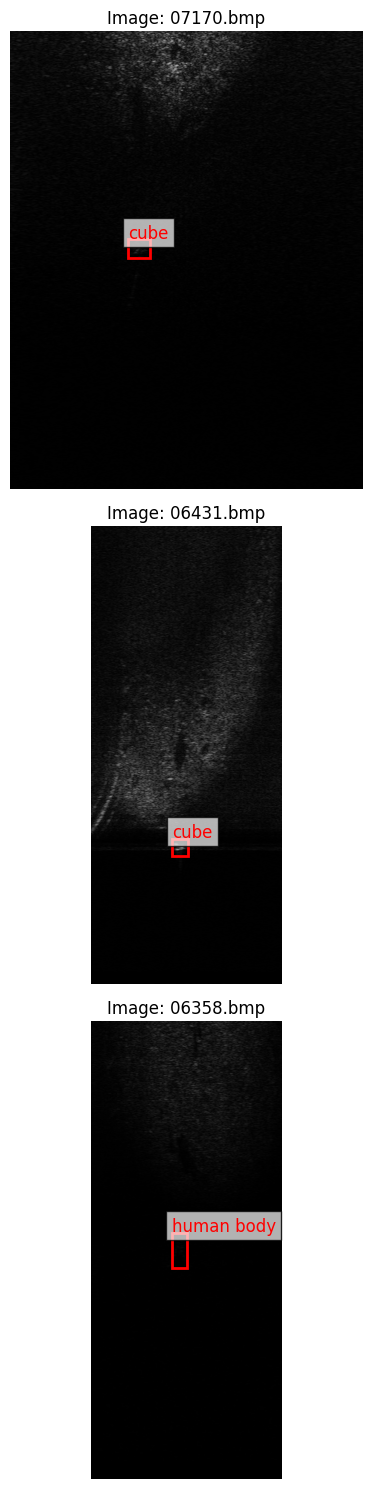

In [ ]:
# Visualize samples with annotations
print("\nVisualizing sample training images:")
visualize_samples_with_annotations(train_data, TRAIN_IMAGES_DIR, num_samples=3)


Visualizing data augmentations:


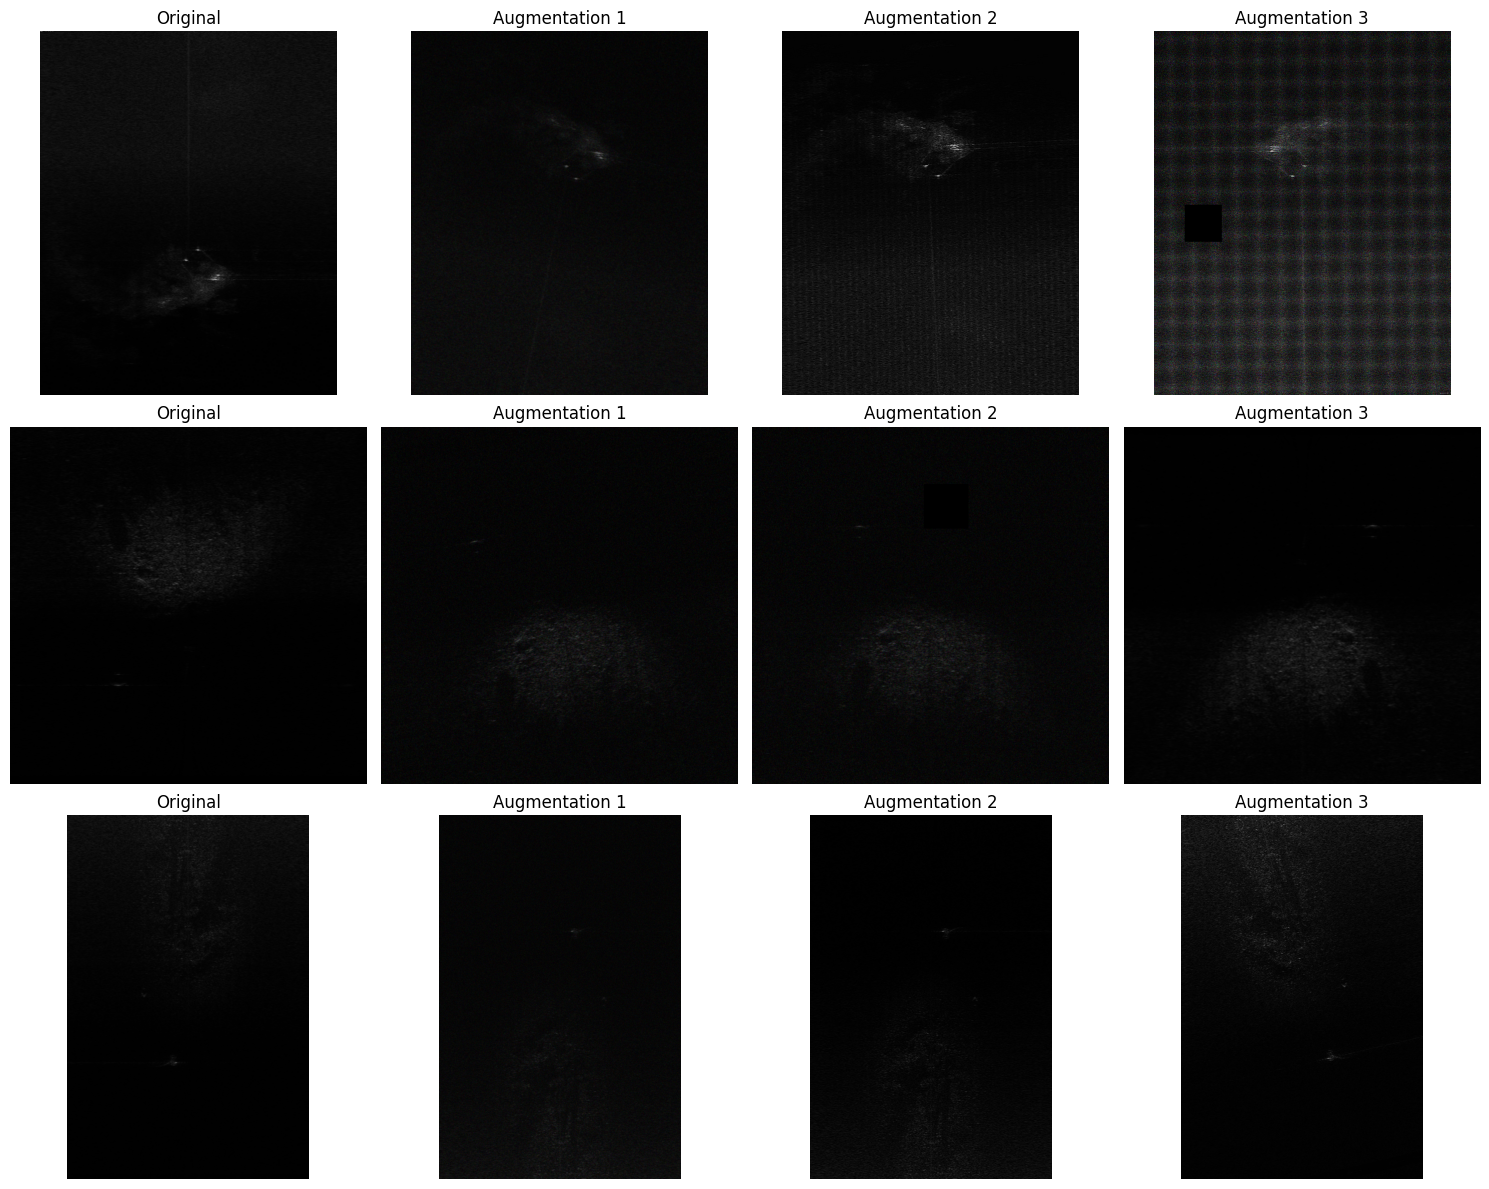

In [ ]:
# Visualize augmentations
print("\nVisualizing data augmentations:")
visualize_augmentations(train_data, TRAIN_IMAGES_DIR, num_samples=3)

In [ ]:
# Create data generators
print("\nCreating data generators...")
train_generator = data_generator(
    train_data,
    TRAIN_IMAGES_DIR,
    CATEGORY_TO_ID,
    batch_size=BATCH_SIZE,
    augment=True
)

val_generator = data_generator(
    val_data,
    TRAIN_IMAGES_DIR,
    CATEGORY_TO_ID,
    batch_size=BATCH_SIZE,
    augment=False
)

test_generator = data_generator(
    test_annotations,
    TEST_IMAGES_DIR,
    CATEGORY_TO_ID,
    batch_size=BATCH_SIZE,
    augment=False
)



Creating data generators...


##Training


Building CNN model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "ObjectDetection_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 3,588,174 (13.69 MB)

 Trainable params: 1,328,142 (5.07 MB)

 Non-trainable params: 2,260,032 (8.62 MB)

None

Training CNN model...
Epoch 1/3
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - bbox_output_loss: 0.0976 - bbox_output_mae: 0.2375 - class_output_accuracy: 0.3586 - class_output_loss: 2.1853 - loss: 2.2829
Epoch 1: val_loss improved from inf to 1.84047, saving model to best_cnn_model.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 1170s 3s/step - bbox_output_loss: 0.0975 - bbox_output_mae: 0.2374 - class_output_accuracy: 0.3587 - class_output_loss: 2.1845 - loss: 2.2820 - val_bbox_output_loss: 0.0154 - val_bbox_output_mae: 0.0854 - val_class_output_accuracy: 0.4234 - val_class_output_loss: 1.8251 - val_loss: 1.8405 - learning_rate: 0.0010
Epoch 2/3
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - bbox_output_loss: 0.0169 - bbox_output_mae: 0.0893 - class_output_accuracy: 0.4686 - class_output_loss: 1.5731 - loss: 1.5902
Epoch 2: val_loss improved from 1.84047 to 1.59489, saving model to best_cnn_model.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 1163s 3s/step - bbox_output_loss: 0.0169 - bbox_output_mae: 0.0893 - class_output_accuracy: 0.4686 - class_output_loss: 1.5731 - loss: 1.5902 - val_bbox_output_loss: 0.0411 - val_bbox_output_mae: 0.1598 - val_class_output_accuracy: 0.4604 - val_class_output_loss: 1.5538 - val_loss: 1.5949 - learning_rate: 0.0010
Epoch 3/3
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - bbox_output_loss: 0.0126 - bbox_output_mae: 0.0783 - class_output_accuracy: 0.4903 - class_output_loss: 1.4971 - loss: 1.5106
Epoch 3: val_loss improved from 1.59489 to 1.45620, saving model to best_cnn_model.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 1172s 3s/step - bbox_output_loss: 0.0126 - bbox_output_mae: 0.0783 - class_output_accuracy: 0.4903 - class_output_loss: 1.4971 - loss: 1.5106 - val_bbox_output_loss: 0.0134 - val_bbox_output_mae: 0.0794 - val_class_output_accuracy: 0.5097 - val_class_output_loss: 1.4428 - val_loss: 1.4562 - learning_rate: 0.0010

CNN training results:


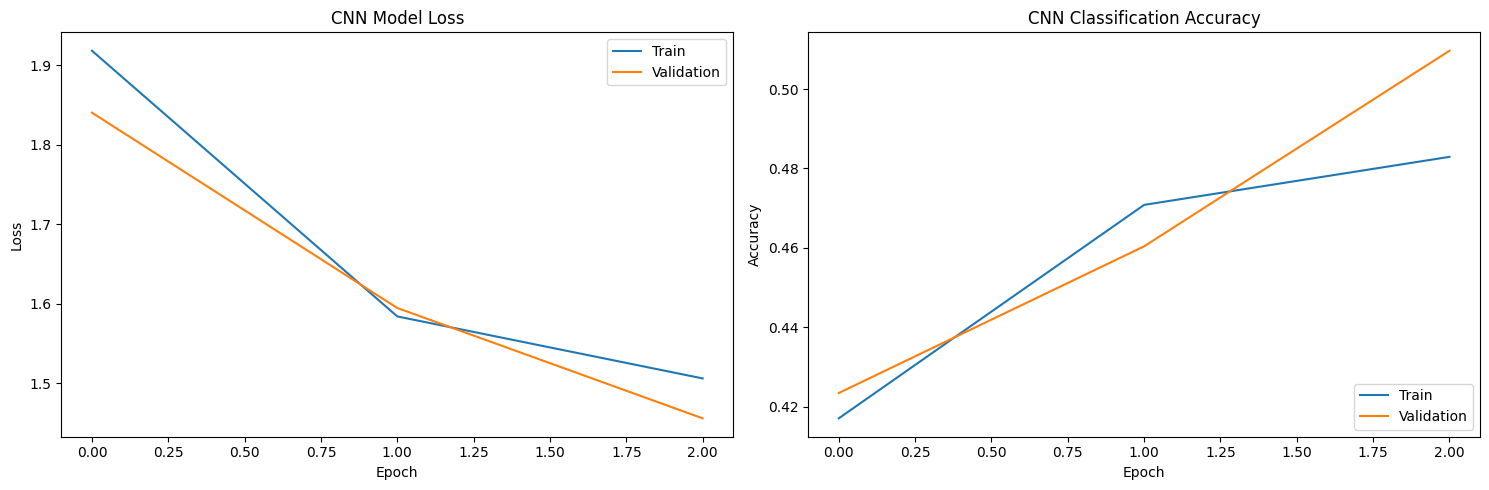

In [ ]:
# Build CNN model
print("\nBuilding CNN model...")
num_classes = len(categories)
cnn_model = build_cnn_model(num_classes)
print(cnn_model.summary())

# Train CNN model
print("\nTraining CNN model...")
cnn_history = train_cnn_model(cnn_model, train_generator, val_generator)

# Plot training history
print("\nCNN training results:")
plot_training_history(cnn_history, "CNN")

##Fine-Tuning

In [ ]:
# Fine-tune CNN model
print("\nFine-tuning CNN model...")
fine_tune_history = unfreeze_and_fine_tune(cnn_model, train_generator, val_generator)


Fine-tuning CNN model...
Epoch 1/5
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - bbox_output_loss: 0.0276 - bbox_output_mae: 0.1134 - class_output_accuracy: 0.2792 - class_output_loss: 2.9233 - loss: 2.9508
Epoch 1: val_loss improved from inf to 3.04478, saving model to best_fine_tuned_model.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 1284s 3s/step - bbox_output_loss: 0.0275 - bbox_output_mae: 0.1134 - class_output_accuracy: 0.2794 - class_output_loss: 2.9220 - loss: 2.9496 - val_bbox_output_loss: 0.0139 - val_bbox_output_mae: 0.0848 - val_class_output_accuracy: 0.1032 - val_class_output_loss: 3.0224 - val_loss: 3.0448 - learning_rate: 1.0000e-04
Epoch 2/5
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - bbox_output_loss: 0.0198 - bbox_output_mae: 0.0970 - class_output_accuracy: 0.4095 - class_output_loss: 1.8321 - loss: 1.8519
Epoch 2: val_loss improved from 3.04478 to 2.86943, saving model to best_fine_tuned_model.h5


403/403 ━━━━━━━━━━━━━━━━━━━━ 1226s 3s/step - bbox_output_loss: 0.0198 - bbox_output_mae: 0.0970 - class_output_accuracy: 0.4095 - class_output_loss: 1.8320 - loss: 1.8518 - val_bbox_output_loss: 0.0149 - val_bbox_output_mae: 0.0861 - val_class_output_accuracy: 0.1673 - val_class_output_loss: 2.8505 - val_loss: 2.8694 - learning_rate: 1.0000e-04
Epoch 3/5
364/403 ━━━━━━━━━━━━━━━━━━━━ 1:56 3s/step - bbox_output_loss: 0.0153 - bbox_output_mae: 0.0876 - class_output_accuracy: 0.4514 - class_output_loss: 1.5971 - loss: 1.6124

In [ ]:
# Plot fine-tuning history
print("\nCNN fine-tuning results:")
plot_training_history(fine_tune_history, "Fine-tuned CNN")

In [ ]:
# Evaluate CNN model on test set
print("\nEvaluating CNN model on test set...")
test_steps = len(test_annotations) // BATCH_SIZE
cnn_evaluation = evaluate_model(cnn_model, test_generator, test_steps)
print("CNN Model Evaluation:")
for metric, value in cnn_evaluation.items():
    print(f"{metric}: {value:.4f}")

##Save CNN model

In [ ]:
# Save CNN model
cnn_model.save('underwater_object_detection_cnn.h5')
print("\nCNN model saved as 'underwater_object_detection_cnn.h5'")

##Siamese

In [ ]:
# Create image pairs
print("\nCreating image pairs for Siamese network...")
train_pairs, train_labels = create_image_pairs(train_data, TRAIN_IMAGES_DIR, CATEGORY_TO_ID)
val_pairs, val_labels = create_image_pairs(val_data, TRAIN_IMAGES_DIR, CATEGORY_TO_ID, num_pairs=NUM_PAIRS//4)
test_pairs, test_labels = create_image_pairs(test_annotations, TEST_IMAGES_DIR, CATEGORY_TO_ID, num_pairs=NUM_PAIRS//4)

# Process image pairs
print("\nProcessing image pairs...")
train_siamese_data = process_image_pairs(train_pairs, train_labels)
val_siamese_data = process_image_pairs(val_pairs, val_labels)
test_siamese_data = process_image_pairs(test_pairs, test_labels)


In [ ]:
 #Build Siamese network
print("\nBuilding Siamese network...")
siamese_model, encoder = build_siamese_network()
print(siamese_model.summary())

In [ ]:
# Train Siamese network
print("\nTraining Siamese network...")
siamese_history = train_siamese_network(siamese_model, train_siamese_data, val_siamese_data)


In [ ]:
# Plot Siamese training history
print("\nSiamese network training results:")
plot_siamese_training_history(siamese_history)


In [ ]:
# Evaluate Siamese network on test set
print("\nEvaluating Siamese network on test set...")
siamese_evaluation = siamese_model.evaluate(test_siamese_data[0], test_siamese_data[1])
print(f"Test Loss: {siamese_evaluation[0]:.4f}")
print(f"Test Accuracy: {siamese_evaluation[1]:.4f}")

In [ ]:
# Save Siamese network
siamese_model.save('underwater_object_detection_siamese.h5')
print("\nSiamese model saved as 'underwater_object_detection_siamese.h5'")


##Comparison

In [ ]:
# Compare model performances
print("\nModel Comparison:")
print(f"CNN Classification Accuracy: {cnn_evaluation.get('class_output_accuracy', 0):.4f}")
print(f"Siamese Network Accuracy: {siamese_evaluation[1]:.4f}")

# Create a comparison bar chart
plt.figure(figsize=(10, 6))
models = ['CNN', 'Siamese Network']
accuracies = [cnn_evaluation.get('class_output_accuracy', 0), siamese_evaluation[1]]
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()